In [1]:
!conda env list

# conda environments:
#
base                  *  /home/cesar/anaconda3
pyspark                  /home/cesar/anaconda3/envs/pyspark
sat                      /home/cesar/anaconda3/envs/sat



In [2]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import tarfile
from six.moves.urllib.request import urlretrieve

In [3]:
manualSeed = 999
print("Random Seed :", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

trainning_loop = True

nc = 3   # input image channels
nz = 100 # size of the latent z vector
ngf = 64 # n growth factor
ndf = 64 # n decrease factor

image_size = 32
batch_size = 32
niter = 50000
num_workers = 0

Diters = 5             # number of D iters per each G iter
lrD = 0.0005          # learning rate for Critic
lrG = 0.0005          # learning rate for Generator
clamp_lower = -0.01
clamp_upper = 0.01

PATH_DATA = 'data'
RESULTS_PATH = 'results/wdcgan'

Random Seed : 999


In [4]:
os.makedirs(PATH_DATA, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

In [5]:
def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):

    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(data_dir, fname)
    
    print(fpath)

    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {} : {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
            return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath

In [6]:
data_fpath = get_file(fname='emojis', 
                      origin='http://www.cs.toronto.edu/~jba/emojis.tar.gz', 
                      untar=True)

data/emojis.tar.gz


In [7]:
def get_emoji_loader(emoji_type, image_size, batch_size, num_workers):

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    img_path = os.path.join('data/emojis', emoji_type)

    dataset = dset.ImageFolder(img_path, transform)

    dloader = DataLoader(dataset=dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers)

    return dloader

In [8]:
dataloader = get_emoji_loader("Apple", image_size, batch_size, num_workers)

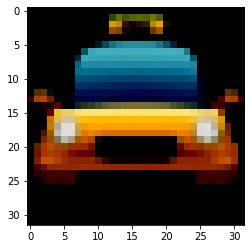

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

data = next(iter(dataloader))
np_img = np.transpose(data[0][0].numpy(), (1, 2, 0))
plt.imshow(np.clip(np_img, 0, 1))
plt.show()

In [10]:
class DCGAN_D(nn.Module):
    def __init__(self, isize, nz, nc, ndf):
        super(DCGAN_D, self).__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        main = nn.Sequential()
        # input is nc x isize x isize
        main.add_module('initial:{0}-{1}:conv'.format(nc, ndf),
                        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
        main.add_module('initial:{0}:relu'.format(ndf),
                        nn.LeakyReLU(0.2, inplace=True))
        csize, cndf = isize / 2, ndf

        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2
            main.add_module('pyramid:{0}-{1}:conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))
            main.add_module('pyramid:{0}:batchnorm'.format(out_feat),
                            nn.BatchNorm2d(out_feat))
            main.add_module('pyramid:{0}:relu'.format(out_feat),
                            nn.LeakyReLU(0.2, inplace=True))
            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
        main.add_module('final:{0}-{1}:conv'.format(cndf, 1),
                        nn.Conv2d(cndf, 1, 4, 1, 0, bias=False))
        self.main = main


    def forward(self, input):
        output = self.main(input)    
        output = output.mean(0)
        return output.view(1)

In [11]:
class DCGAN_G(nn.Module):
    def __init__(self, isize, nz, nc, ngf):
        super(DCGAN_G, self).__init__()
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        cngf, tisize = ngf//2, 4
        while tisize != isize:
            cngf = cngf * 2
            tisize = tisize * 2

        main = nn.Sequential()
        # input is Z, going into a convolution
        main.add_module('initial:{0}-{1}:convt'.format(nz, cngf),
                        nn.ConvTranspose2d(nz, cngf, 4, 1, 0, bias=False))
        main.add_module('initial:{0}:batchnorm'.format(cngf),
                        nn.BatchNorm2d(cngf))
        main.add_module('initial:{0}:relu'.format(cngf),
                        nn.ReLU(True))

        csize, cndf = 4, cngf
        while csize < isize//2:
            main.add_module('pyramid:{0}-{1}:convt'.format(cngf, cngf//2),
                            nn.ConvTranspose2d(cngf, cngf//2, 4, 2, 1, bias=False))
            main.add_module('pyramid:{0}:batchnorm'.format(cngf//2),
                            nn.BatchNorm2d(cngf//2))
            main.add_module('pyramid:{0}:relu'.format(cngf//2),
                            nn.ReLU(True))
            cngf = cngf // 2
            csize = csize * 2

        main.add_module('final:{0}-{1}:convt'.format(cngf, nc),
                        nn.ConvTranspose2d(cngf, nc, 4, 2, 1, bias=False))
        main.add_module('final:{0}:tanh'.format(nc),
                        nn.Tanh())
        self.main = main

    def forward(self, input):
        output = self.main(input)
        return output 

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [14]:
netG = DCGAN_G(image_size, nz, nc, ngf)
netG.apply(weights_init)

DCGAN_G(
  (main): Sequential(
    (initial:100-256:convt): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (initial:256:batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (initial:256:relu): ReLU(inplace=True)
    (pyramid:256-128:convt): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:128:batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:128:relu): ReLU(inplace=True)
    (pyramid:128-64:convt): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:64:batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:64:relu): ReLU(inplace=True)
    (final:64-3:convt): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (final:3:tanh): Tanh()
  )
)

In [15]:
netD = DCGAN_D(image_size, nz, nc, ndf)
netD.apply(weights_init)

DCGAN_D(
  (main): Sequential(
    (initial:3-64:conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (initial:64:relu): LeakyReLU(negative_slope=0.2, inplace=True)
    (pyramid:64-128:conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:128:batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:128:relu): LeakyReLU(negative_slope=0.2, inplace=True)
    (pyramid:128-256:conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (pyramid:256:batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid:256:relu): LeakyReLU(negative_slope=0.2, inplace=True)
    (final:256-1:conv): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [16]:
input = torch.FloatTensor(batch_size, 3, image_size, image_size)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)
one = torch.FloatTensor([1])
mone = one * -1

In [17]:
if torch.cuda.is_available():
    cuda_opt = True
    netD.cuda()
    netG.cuda()
    input = input.cuda()
    one, mone = one.cuda(), mone.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

In [18]:
optimizerD = optim.RMSprop(netD.parameters(), lr=lrD)
optimizerG = optim.RMSprop(netG.parameters(), lr=lrG)

In [19]:
gen_iterations = 0
lossD_dict = []
lossG_dict = []

for epoch in range(niter):
    
    data_iter = iter(dataloader)
    i = 0
    errD_cum = 0
    errG_cum = 0


    while i < len(dataloader):
        
        ############################
        # (1) Update D network
        ###########################
        
        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True # they are set to False below in netG update

        # train the discriminator Diters times
        if gen_iterations < 25 or gen_iterations % 500 == 0:
            cDiters = 100
        else:
            cDiters = Diters
        j = 0
        
        while j < cDiters and i < len(dataloader):
            
            j += 1

            data = data_iter.next()
            i += 1

            # train with real
            real_cpu, _ = data
            netD.zero_grad()
            batch_size = real_cpu.size(0)

            if cuda_opt:
                real_cpu = real_cpu.cuda()
            input.resize_as_(real_cpu).copy_(real_cpu)
            inputv = torch.autograd.Variable(input)

            errD_real = netD(inputv)
            errD_real.backward(one)

            # train with fake
            noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
            noisev = torch.autograd.Variable(noise, volatile = True) # totally freeze netG
            fake = torch.autograd.Variable(netG(noisev).data)
            inputv = fake
            errD_fake = netD(inputv)
            errD_fake.backward(mone)
            errD = errD_real - errD_fake
            optimizerD.step()
            
            # clamp parameters to a cube
            for p in netD.parameters():
                p.data.clamp_(clamp_lower, clamp_upper)

        ############################
        # (2) Update G network
        ###########################
        for p in netD.parameters():
            p.requires_grad = False # to avoid computation
        netG.zero_grad()
        # in case our last batch was the tail batch of the dataloader,
        # make sure we feed a full batch of noise
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = torch.autograd.Variable(noise)
        fake = netG(noisev)
        errG = netD(fake)
        errG.backward(one)
        optimizerG.step()
        gen_iterations += 1
            
        errD_cum += errD
        errG_cum += errG
        
    lossD_dict.append(errD_cum)
    lossG_dict.append(errG_cum)
    
    if epoch % 1000 == 0:
        real_cpu = real_cpu.mul(0.5).add(0.5)
        vutils.save_image(real_cpu, '{0}/real_samples.png'.format(RESULTS_PATH))
        fake = netG(torch.autograd.Variable(fixed_noise, volatile=True))
        fake.data = fake.data.mul(0.5).add(0.5)
        vutils.save_image(fake.data, '{0}/fake_samples_{1}.png'.format(RESULTS_PATH,
                                                                       gen_iterations))
        
    if epoch % 100 == 0:
        print('[%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake %f'
            % (epoch, errD.data[0], errG.data[0], errD_real.data[0], errD_fake.data[0]))

    if epoch % 1000 == 0:
        torch.save(netG.state_dict(), '{0}/netG_epoch_{1}.pth'.format(RESULTS_PATH, epoch))
        torch.save(netD.state_dict(), '{0}/netD_epoch_{1}.pth'.format(RESULTS_PATH, epoch))

[0] Loss_D: -0.732012 Loss_G: 0.397354 Loss_D_real: -0.385385 Loss_D_fake 0.346628
[100] Loss_D: -0.119897 Loss_G: 0.200913 Loss_D_real: -0.239352 Loss_D_fake -0.119455
[200] Loss_D: -0.074271 Loss_G: 0.072006 Loss_D_real: -0.213446 Loss_D_fake -0.139175
[300] Loss_D: -0.079528 Loss_G: 0.136222 Loss_D_real: -0.220373 Loss_D_fake -0.140846
[400] Loss_D: -0.061325 Loss_G: 0.019688 Loss_D_real: -0.015201 Loss_D_fake 0.046124
[500] Loss_D: -0.019084 Loss_G: 0.060692 Loss_D_real: -0.103467 Loss_D_fake -0.084383
[600] Loss_D: -0.090209 Loss_G: 0.025649 Loss_D_real: 0.058163 Loss_D_fake 0.148372
[700] Loss_D: -0.057698 Loss_G: -0.048196 Loss_D_real: -0.050278 Loss_D_fake 0.007420
[800] Loss_D: -0.057519 Loss_G: -0.033722 Loss_D_real: -0.058452 Loss_D_fake -0.000933
[900] Loss_D: -0.069872 Loss_G: 0.064152 Loss_D_real: -0.013175 Loss_D_fake 0.056697
[1000] Loss_D: -0.045432 Loss_G: -0.051551 Loss_D_real: -0.108851 Loss_D_fake -0.063419
[1100] Loss_D: -0.034450 Loss_G: 0.011960 Loss_D_real: 0.0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd113a73b90>
Traceback (most recent call last):
  File "/home/cesar/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/home/cesar/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 939, in _shutdown_workers
    self._shutdown_worker(worker_id)
  File "/home/cesar/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 895, in _shutdown_worker
    q.put(None)
  File "/home/cesar/anaconda3/lib/python3.7/multiprocessing/queues.py", line 89, in put
    self._notempty.notify()
  File "/home/cesar/anaconda3/lib/python3.7/threading.py", line 351, in notify
    for waiter in waiters_to_notify:
  File "/home/cesar/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 30810) is kil

RuntimeError: DataLoader worker (pid(s) 30810) exited unexpectedly

In [2]:
rand = torch.empty(1, nz, 1, 1).normal_(mean=0, std=1).cuda()
print(rand.size())
img_gen = netG(rand).view(3, 32, 32).detach().cpu().numpy()
img_gen = np.transpose(img_gen, (1, 2, 0))
img_gen = np.clip(img_gen, 0, 1)
plt.imshow(img_gen)
plt.show()

NameError: name 'torch' is not defined